<a href="https://colab.research.google.com/github/lapidesd/CA_missing_freshet/blob/main/Colab_notebooks/April_1_SWE_vs_streamflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
! pip install geopandas
import geopandas as gpd
import numpy as np
%config InlineBackend.figure_format = 'retina'

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
! pip install hydrofunctions
import hydrofunctions as hf
import matplotlib.font_manager as fm
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.2 MB/s 
     |████████████████████████████████| 16.7 MB 423 kB/s 
     |████████████████████████████████| 6.3 MB 16.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 4.4 MB/s 
     |████████████████████████████████| 1.6 MB 11.4 MB/s 
--2022-09-07 21:35:21--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2022-09-07 21:35:21--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunne

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


## Import information about study sites

In [3]:
# import shapefile of study sites and site info
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_list.zip'
loc1 = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/KREW_gages.zip'
gages = gpd.read_file(loc).to_crs(epsg = 4326)
gages1 = gpd.read_file(loc1).to_crs(epsg = 4326)
gages1['SITE_NO'] = gages1.Name
gages1['STATION_NM'] = ['Providence 300',
                        'Providence 301',
                        'Providence 303',
                        'Providence 304',
                        'Bull D102',
                        'Bull B200',
                        'Bull B201',
                        'Bull B203',
                        'Bull B204',
                        'Bull T003']
gages1.drop(columns=['Site','Northing','Easting','Name'],inplace=True)
gages1['LON_SITE'] = [p.x for p in gages1.geometry]
gages1['LAT_SITE'] = [p.y for p in gages1.geometry]
gages1 = gages1.iloc[[0,5]]
gages = pd.concat([gages,gages1])
# import basin outlines
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_watershed_boundaries.zip'
loc1 = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/KREW_watersheds.zip'
basin_outlines = gpd.read_file(loc).to_crs(epsg = 4326)
basin_outlines1 = gpd.read_file(loc1).rename(columns={'watershed':'SITE_NO'}).to_crs(epsg=4326)
basin_outlines1['SQMI'] = basin_outlines1.Area_ha*0.00386102
basin_outlines1.drop(columns='Area_ha',inplace=True)
basin_outlines1 = basin_outlines1.iloc[[4,9]]
basin_outlines = pd.concat([basin_outlines,basin_outlines1])
gage_info = gages.merge(basin_outlines,left_on='SITE_NO',
            right_on='SITE_NO')
# US state map from https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-state-and-equivalent-national
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/state_outline.zip'
state_outline = gpd.read_file(loc).to_crs(epsg = 4326)
state_outline = state_outline[state_outline.STUSPS=='CA']

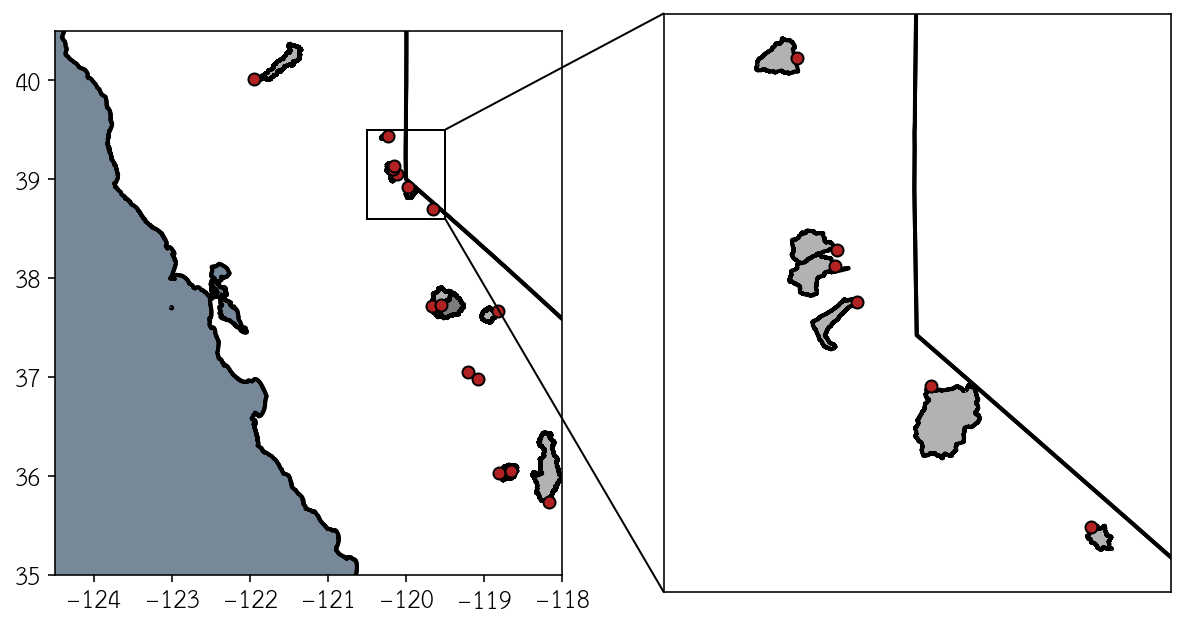

In [4]:
# make a simiple map of the study area
%matplotlib inline
plt.rcParams.update({'font.size': 12})
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

fig,axs = plt.subplots(1,2,figsize=(10,10))

minx, maxx = (-120.5,-119.5)
miny, maxy = (38.6,39.5)

ax = axs[0]
ax.axvspan(-130,-120,facecolor='lightslategray')#,alpha = 0.5)
ax.axhspan(30,35,facecolor='lightslategray')#,alpha=0.5)
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k',facecolor = 'white')
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k')
basin_outlines.boundary.plot(ax=ax,facecolor='k',alpha=0.3)
basin_outlines.boundary.plot(ax=ax,lw=2,edgecolor='k')
gages.plot(ax=ax,marker='o',c='firebrick',zorder = 100,edgecolor = 'k')
ax.set_xlim(-124.5,-118)
ax.set_ylim(35,40.5)

# Create a Rectangle patch
rect = patches.Rectangle((minx,miny), maxx-minx, maxy-miny, linewidth=1, 
                         edgecolor='k', facecolor='none',zorder = 100)
# Add the patch to the Axes
ax.add_patch(rect)




ax = axs[1]
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k')
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k')
basin_outlines.boundary.plot(ax=ax,facecolor='k',alpha=0.3)
basin_outlines.boundary.plot(ax=ax,lw=2,edgecolor='k')
gages.plot(ax=ax,marker='o',c='firebrick',zorder = 100,edgecolor = 'k')
ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)
ax.set_xticks([])
ax.set_yticks([])

con = ConnectionPatch(xyA=(maxx,maxy), xyB=(minx,maxy), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color="k")
ax.add_artist(con)
con = ConnectionPatch(xyA=(maxx,miny), xyB=(minx,miny), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color="k")
ax.add_artist(con)

## Import Snow Water Equivalent (SWE) data from SNODAS
https://nsidc.org/data/g02158#:~:text=SNODAS%20is%20a%20modeling%20and,support%20hydrologic%20modeling%20and%20analysis. 

In [5]:
# import processed SNODAS data, mean for each basin on all dates
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/snodas_basin_data1.csv'
loc1 = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/snodas_basin_data_KREW.csv'
snodas_data = pd.read_csv(loc)
snodas_data['date'] = pd.to_datetime(snodas_data.date)
snodas_data = snodas_data.set_index('date').sort_index()
snodas_data1 = pd.read_csv(loc1)
snodas_data1['date'] = pd.to_datetime(snodas_data1.date)
snodas_data1 = snodas_data1.set_index('date').sort_index()
snodas_data = pd.concat([snodas_data,snodas_data1]).sort_index()

In [6]:
# process data for each study gage from csv format into a dataframe 
# with one column for each site

swe_data = ''

for gage in snodas_data.sitenum.drop_duplicates():
  snowdat = snodas_data[snodas_data.sitenum==gage].drop(columns='sitenum')
  snowdat['wy'] = np.where(snowdat.index.month.isin([10,11,12]),
                           snowdat.index.year+1,snowdat.index.year)    
  if len(swe_data)==0:
    swe_data = snowdat[['swe']].rename(columns={'swe':gage}).dropna()
  else:
    swe_data = swe_data.merge(snowdat[['swe']].rename(columns={'swe':gage}).dropna(),
                              left_index=True,right_index=True).drop_duplicates()

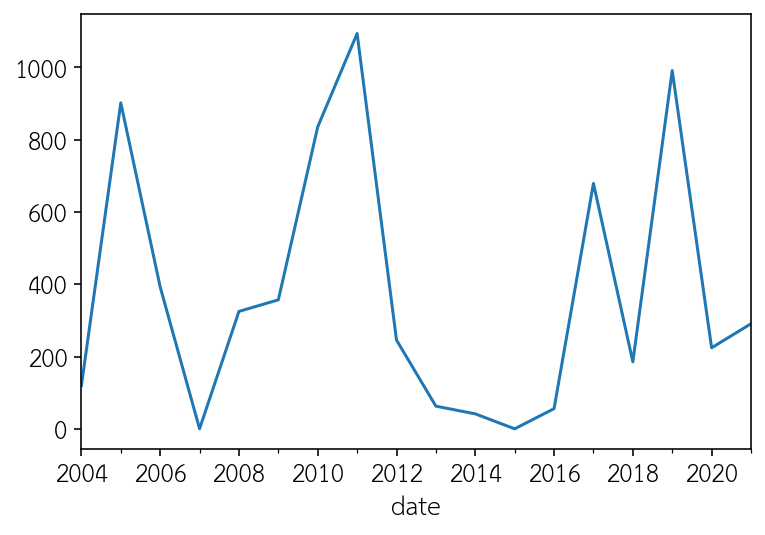

In [7]:
swe_data[(swe_data.index.month==4) & (swe_data.index.day==1)].B200.plot()

## Import streamflow data from NWIS
https://waterdata.usgs.gov/nwis/rt

In [8]:
# get spring streamflow data from NWIS or KREW
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/KREW_flow_mm_day.csv'
krew_flow = pd.read_csv(loc)
krew_flow['Date'] = [pd.to_datetime(d) for d in krew_flow.Date]
krew_flow.set_index('Date',inplace=True)

springflow = {} # total spring streamflow
years = list(range(2001,2022))

for gage in gages.SITE_NO.values:
  try:
    flow_data = hf.NWIS(gage, 'dv', start_date = '2000-10-01',
                        end_date = '2021-10-01').df('00060')
    flow_data = flow_data*12**3*2.54**3/100**3*60*60*24
    # convert to depth (m/d)
    area = (gage_info[gage_info.SITE_NO==gage].SQMI*2.59*1000000).values[0] # are in m2
    flow_data = flow_data/area
    # convert to mm/day
    flow_data = flow_data*1000
  except:
    flow_data = krew_flow[gage+'_Rate'].dropna()
    flow_data = flow_data.to_frame()
    flow_data['wy'] = np.where(flow_data.index.month.isin([10,11,12]),
                              flow_data.index.year+1,flow_data.index.year)
    flow_data = flow_data[~(flow_data.wy==2004) &
                          ~(flow_data.wy==2005) &
                          ~(flow_data.wy==2006) &
                          ~(flow_data.wy==2020)].drop(columns='wy')
  
  
  spring_streamflow = []
  for yr in years:
    try:
      spring_streamflow.append(float(flow_data.loc[pd.to_datetime(str(yr)+'-04-01'):pd.to_datetime(str(yr)+'-09-01')].sum()))
      if spring_streamflow[-1]==0:
        spring_streamflow[-1] = np.nan
    except:
      spring_streamflow.append(np.nan)
  springflow[gage] = spring_streamflow

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336780&startDT=2000-10-01&endDT=2021-10-01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336645&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336660&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336676&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10343500&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10308783&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11383500&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11189500&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11204100&star

ERROR:hydrofunctions.exceptions:The NWIS returned a code of 400.
400 Bad Request - This often occurs if the URL arguments are inconsistent. For example, if you submit a request using a startDT and an endDT with the period argument. An accompanying error should describe why the request was bad.
Error message from NWIS: Bad Request
URL used in this request: https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=P300&startDT=2000-10-01&endDT=2021-10-01


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=P300&startDT=2000-10-01&endDT=2021-10-01


ERROR:hydrofunctions.exceptions:The NWIS returned a code of 400.
400 Bad Request - This often occurs if the URL arguments are inconsistent. For example, if you submit a request using a startDT and an endDT with the period argument. An accompanying error should describe why the request was bad.
Error message from NWIS: Bad Request
URL used in this request: https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=B200&startDT=2000-10-01&endDT=2021-10-01


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=B200&startDT=2000-10-01&endDT=2021-10-01


## Import precipitation information from PRISM

In [9]:

# bring in WY totals from deficit and ET calculations
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/WY_data_allsites.csv'
aggregate_wy_data = pd.read_csv(loc).set_index('wy')

base_loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/site_data_wy_totals/all_deficit_data_'
wy_totals = {}
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = pd.read_csv(base_loc+str(sitenum)+'.csv').set_index('wy')

# combine with April 1 SWE and spring/january streamflow and residuals
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/april_swe_study_sites_mm.csv'
aprilSWE = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/spring_streamflow_mm.csv'
springflow = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/swe_q_residuals_mm.csv'
residuals = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/january_mean_flow_mm_day.csv'
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(aprilSWE[[sitenum]].rename(columns={sitenum:'aprSWE'}),
                                                left_index=True,right_index=True)
  wy_totals[sitenum] = wy_totals[sitenum].merge(springflow[[sitenum]].rename(columns={sitenum:'springQ'}),
                                                left_index=True,right_index=True)
  wy_totals[sitenum] = wy_totals[sitenum].merge(residuals[[sitenum]].rename(columns={sitenum:'residuals'}),
                                                left_index=True,right_index=True)


meanAprSWE = aprilSWE.mean(axis=1).to_frame().rename(columns={0:'aprSWE'})
meanSpringQ = springflow.mean(axis=1).to_frame().rename(columns={0:'springQ'})
res_all = residuals.drop(columns='all_sites').sum(axis=1).to_frame().rename(columns={0:'residuals'})
aggregate_wy_data = aggregate_wy_data.merge(meanAprSWE,left_index=True,right_index=True)
aggregate_wy_data = aggregate_wy_data.merge(meanSpringQ,left_index=True,right_index=True)
aggregate_wy_data = aggregate_wy_data.merge(res_all,left_index=True,right_index=True)

padj_all = ''
for key in wy_totals:
  if len(padj_all)==0:
    padj_all = wy_totals[key][['adjP']].rename(columns={'adjP':key})
  else:
    padj_all = padj_all.merge(wy_totals[key][['adjP']].rename(columns={'adjP':key}),
                              left_index=True,right_index=True)
aggregate_wy_data['adjP'] = padj_all.mean(axis=1)


# bring in melt rates
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/melt_rates.csv'
meltrates = pd.read_csv(loc).set_index('wy')
aggregate_wy_data = aggregate_wy_data.merge(meltrates.mean(axis=1).to_frame().rename(columns={0:'melt_rate'}),
                                            left_index=True, right_index=True)
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(meltrates[[sitenum]].rename(columns={sitenum:'melt_rate'}),
                                                left_index=True, right_index=True)
  
# bring in spring streamflow
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/spring_streamflow_mm.csv'
springflow = pd.read_csv(loc).set_index('wy')
aggregate_wy_data = aggregate_wy_data.merge(springflow.mean(axis=1).to_frame().rename(columns={0:'springflow'}),
                                            left_index=True, right_index=True)
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(springflow[[sitenum]].rename(columns={sitenum:'springflow'}),
                                                left_index=True, right_index=True)


In [10]:
wy_totals['P300'].snow_frac.mean()

0.18859231605469287

## Examine relationship between April 1 SWE and spring runoff

LOO 37.98143956384783
LOO 105.47213770030359
LOO 133.23979213567412
LOO 121.6698510732712
LOO 40.012220564986684
LOO 14.695710578335744
LOO 46.9505979482073
LOO 15.99548033652586
LOO 23.467049234262674
LOO 43.829385957534654
LOO 69.06235778180366
LOO 81.29647199049568
LOO 19.206643858375053
LOO 84.03374145939692
LOO 129.01886467270694


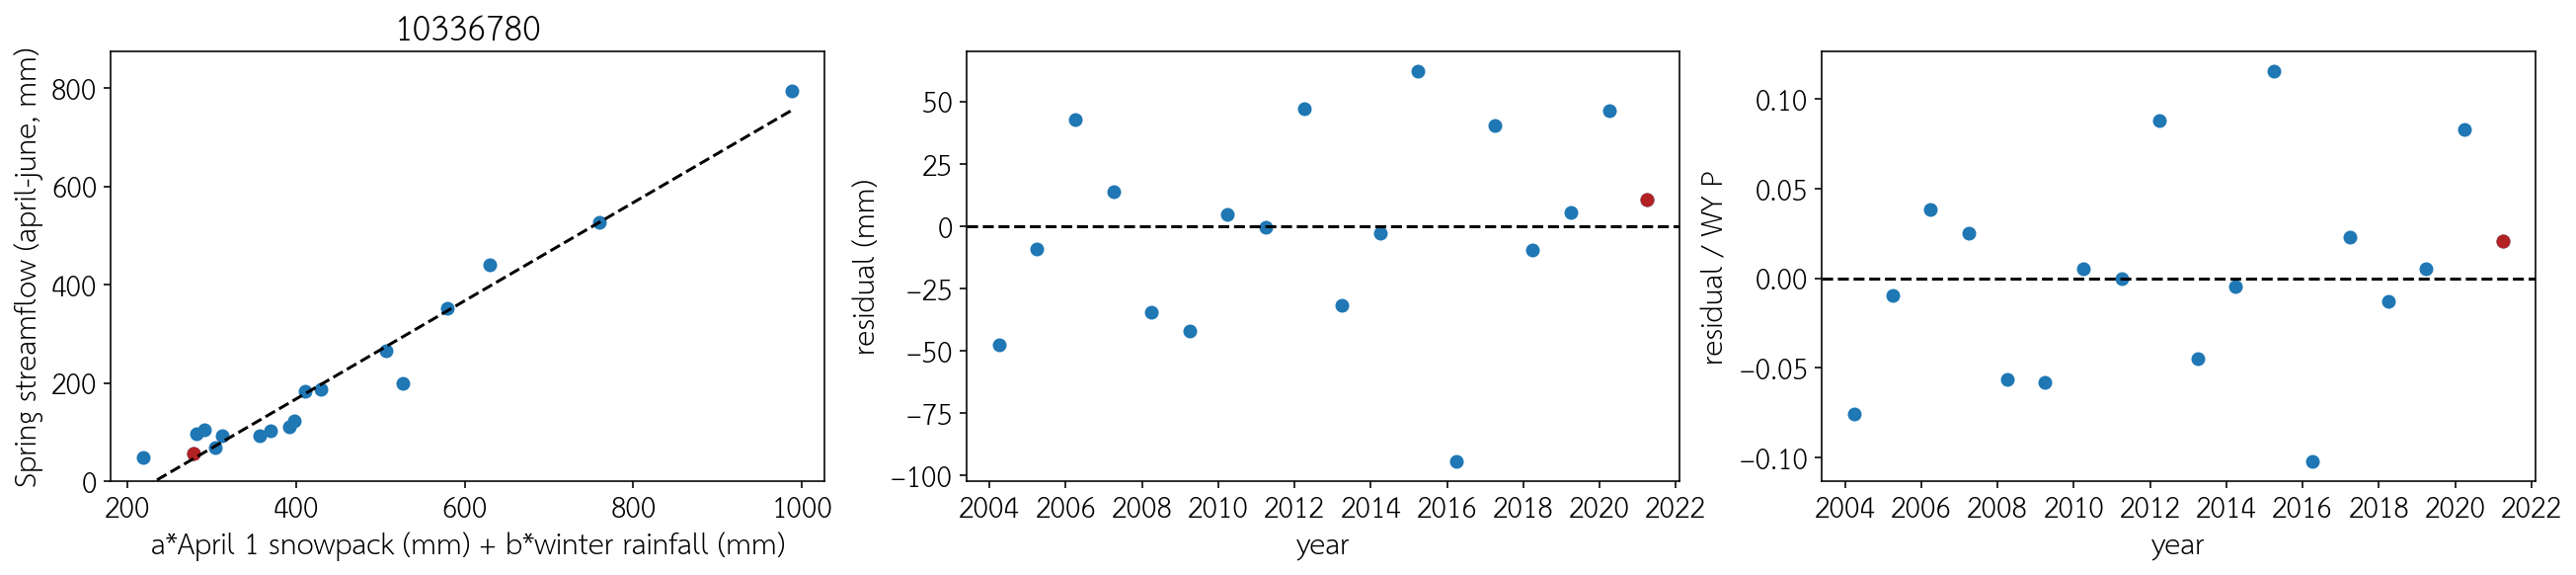

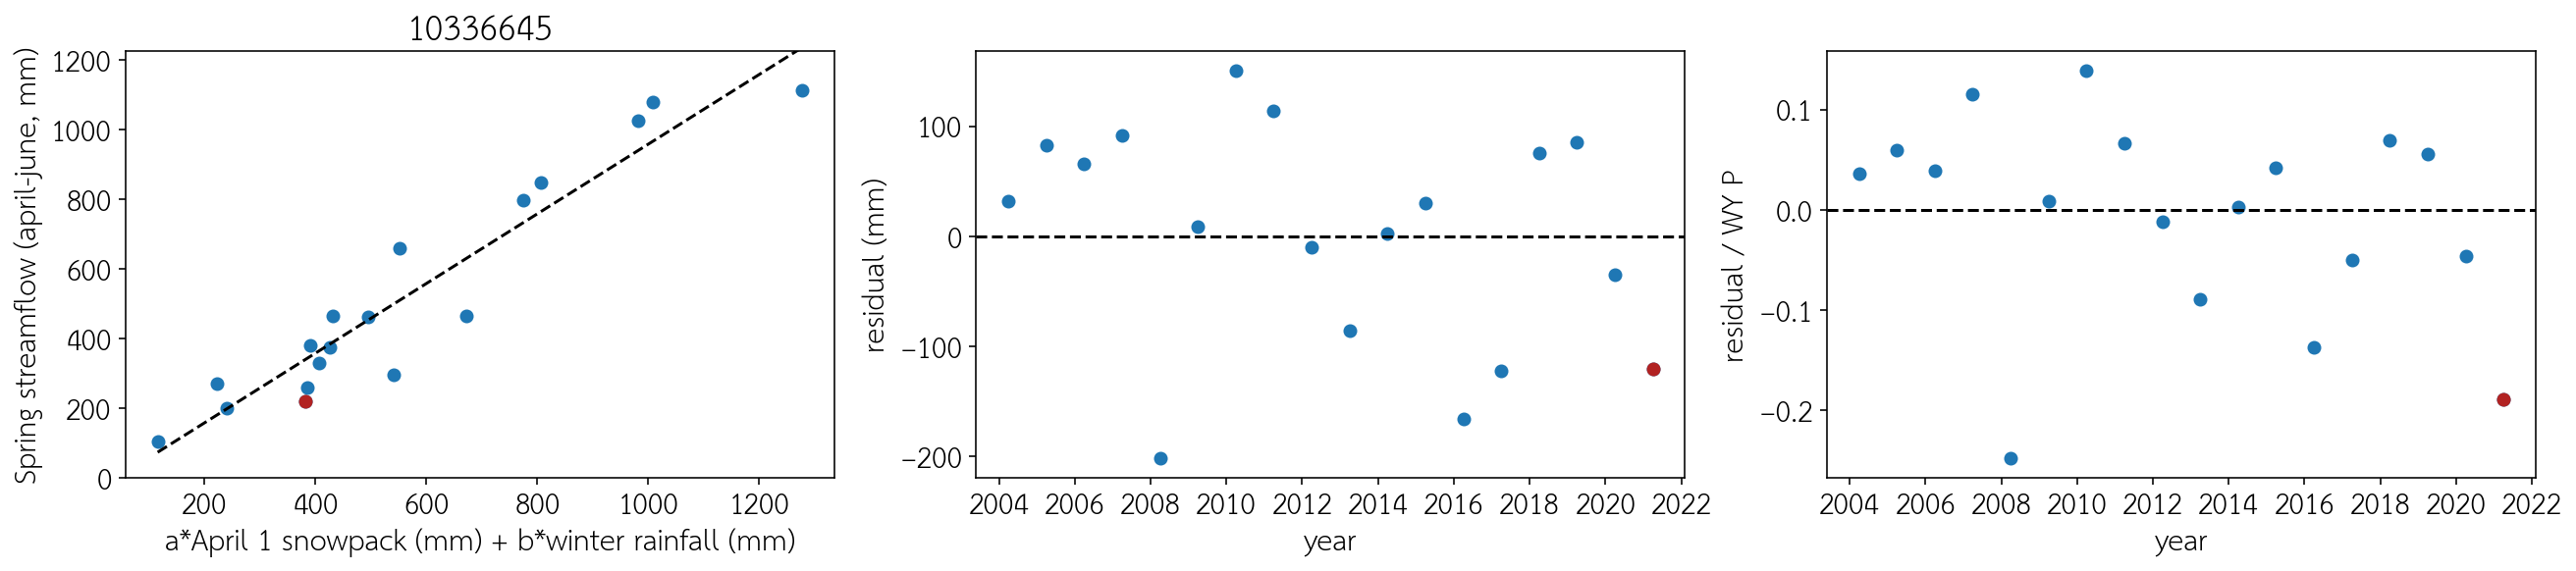

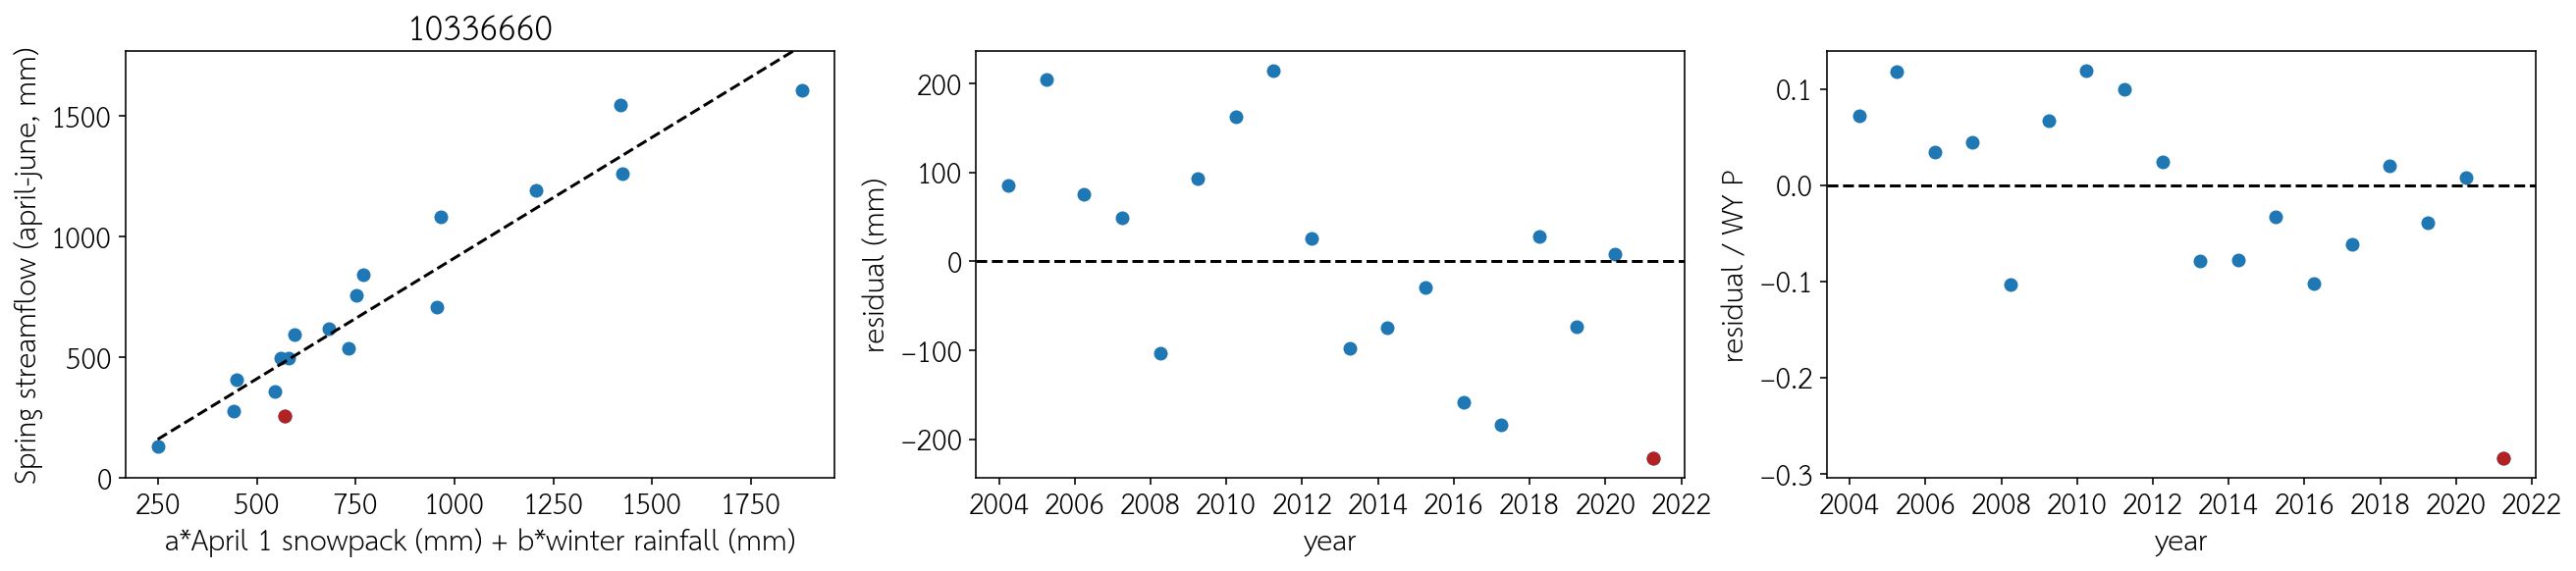

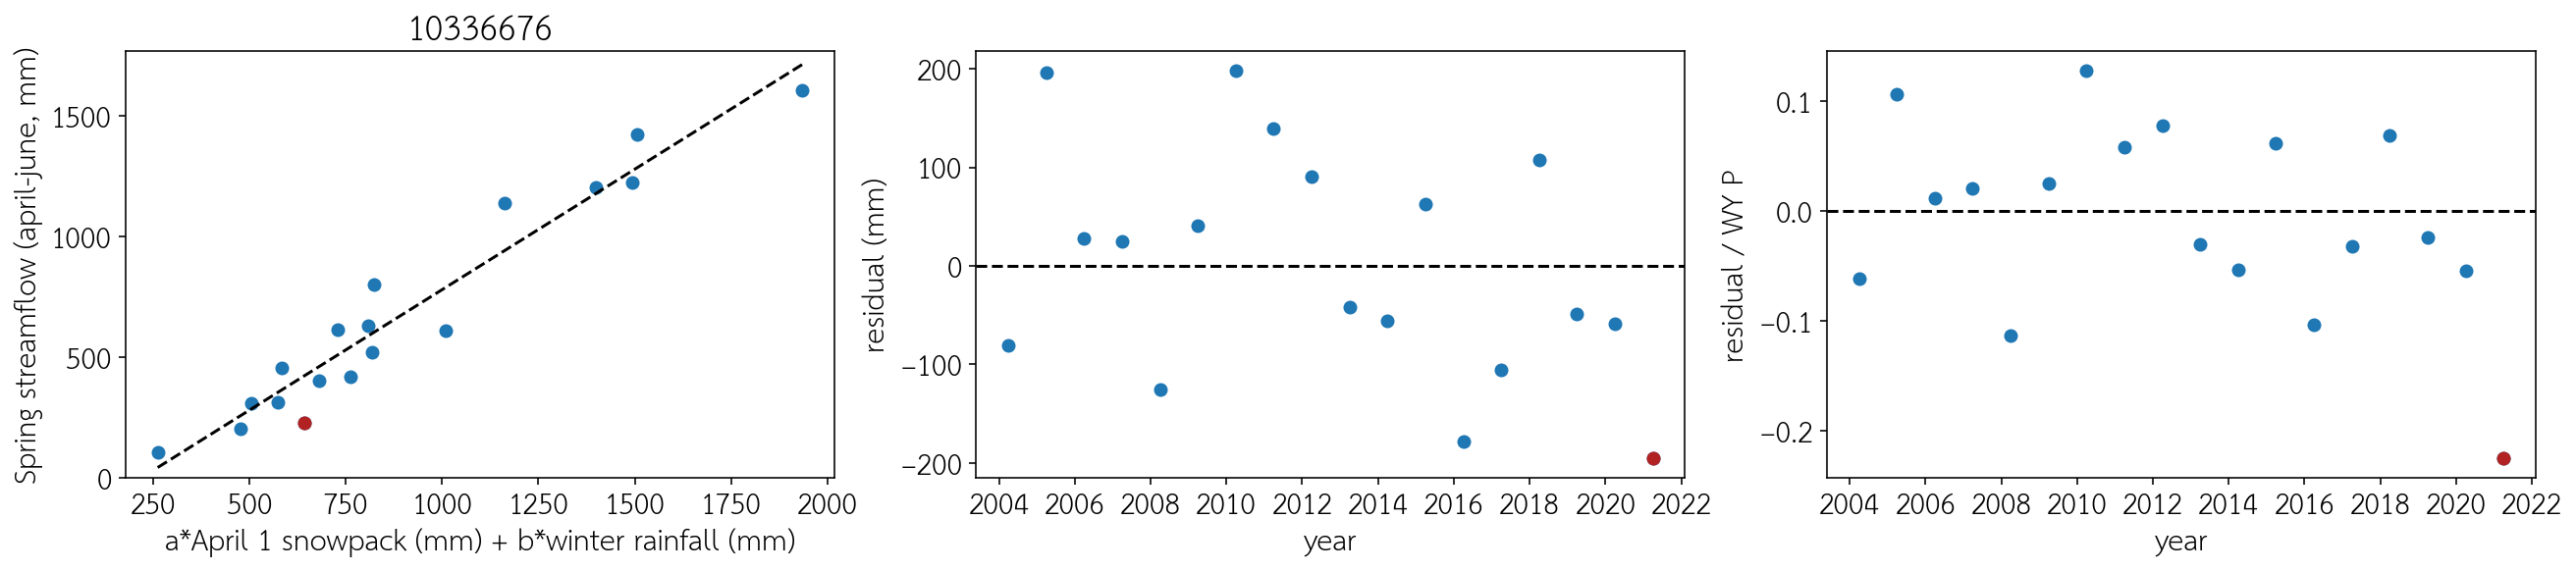

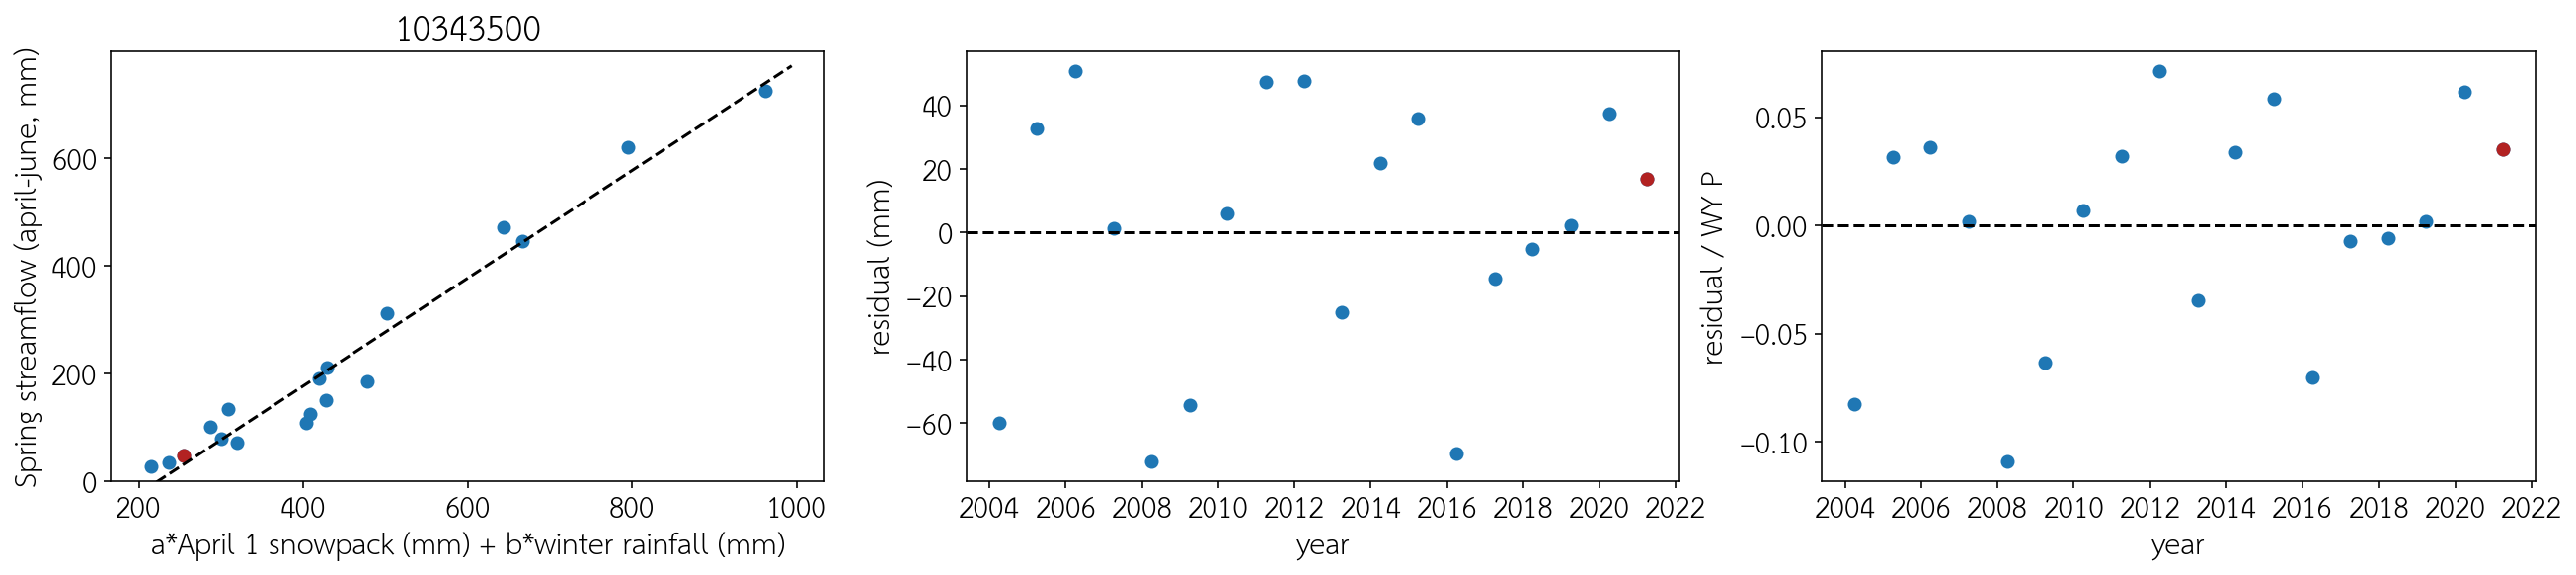

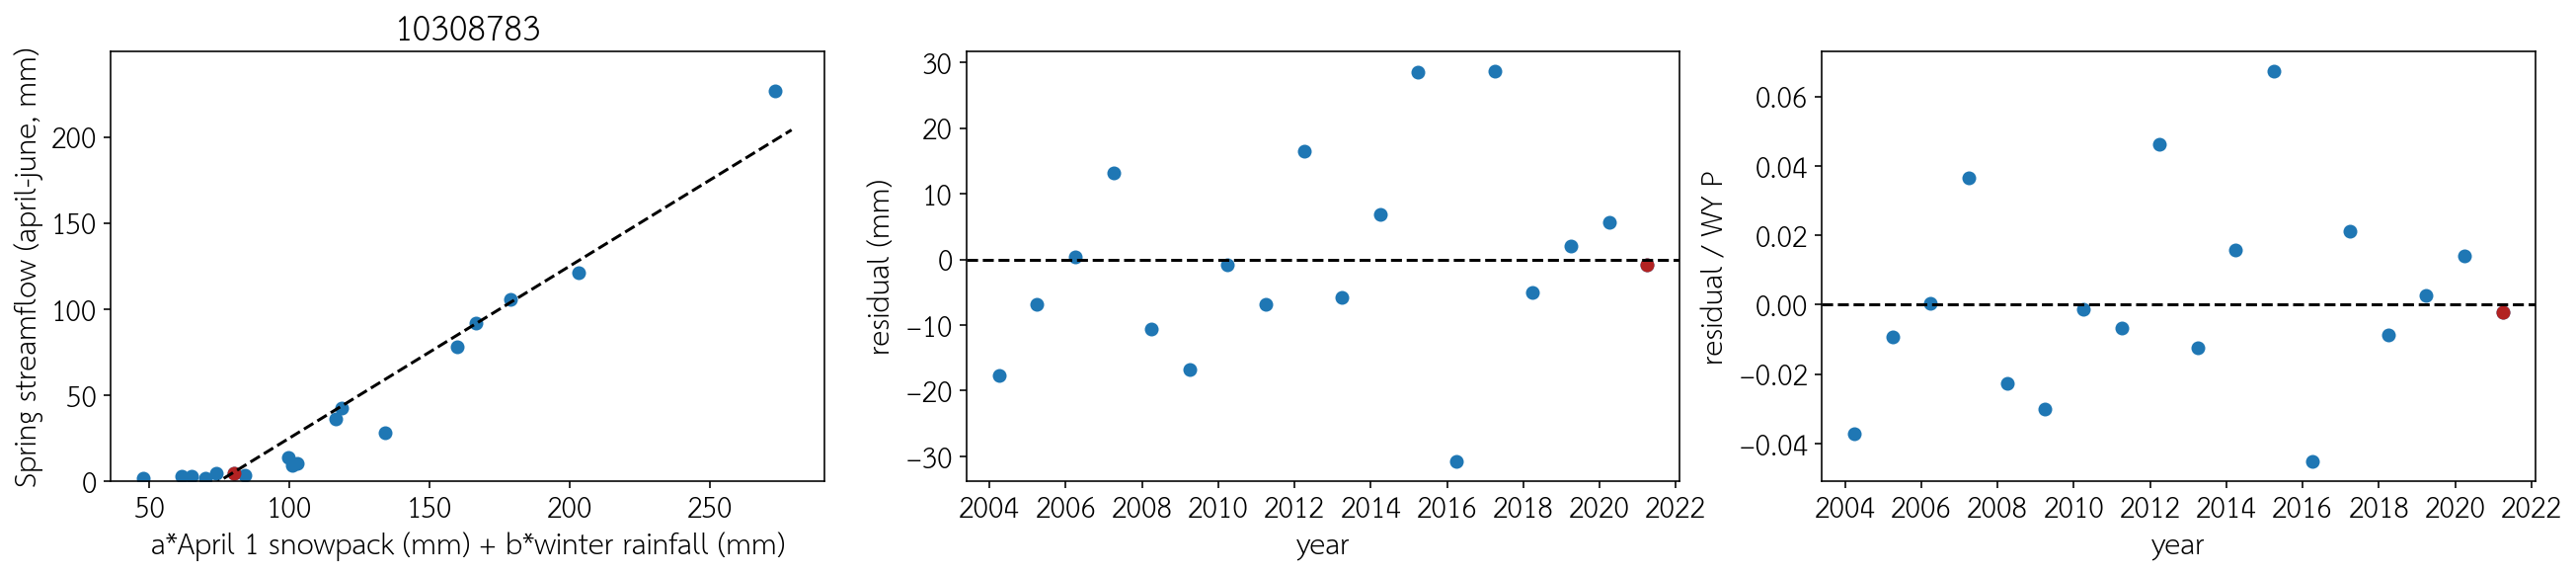

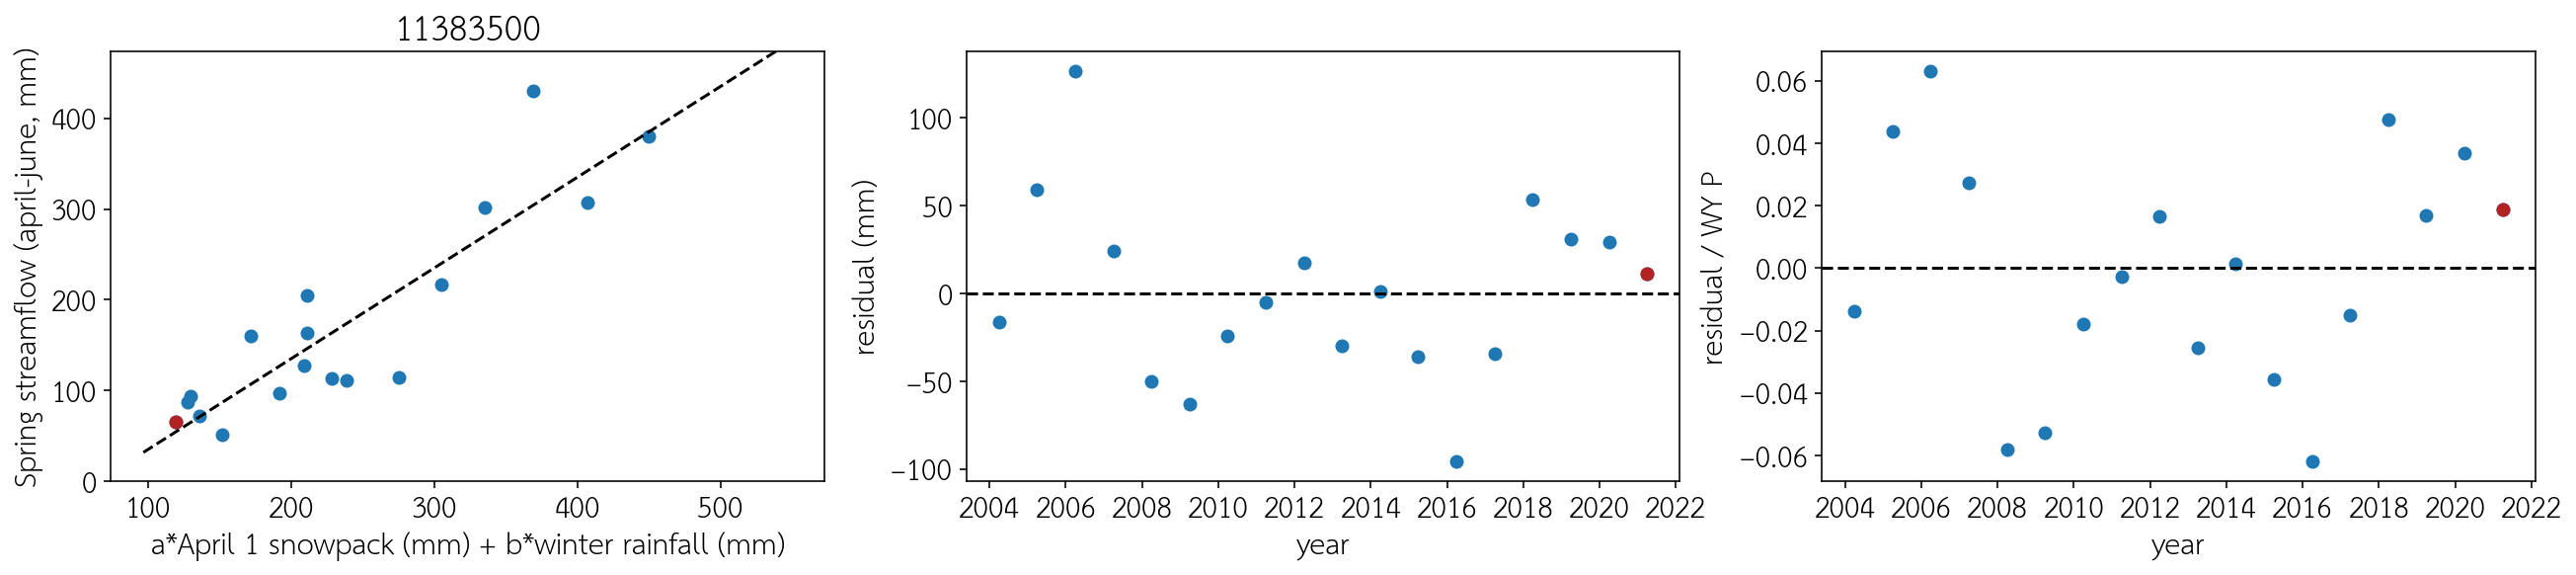

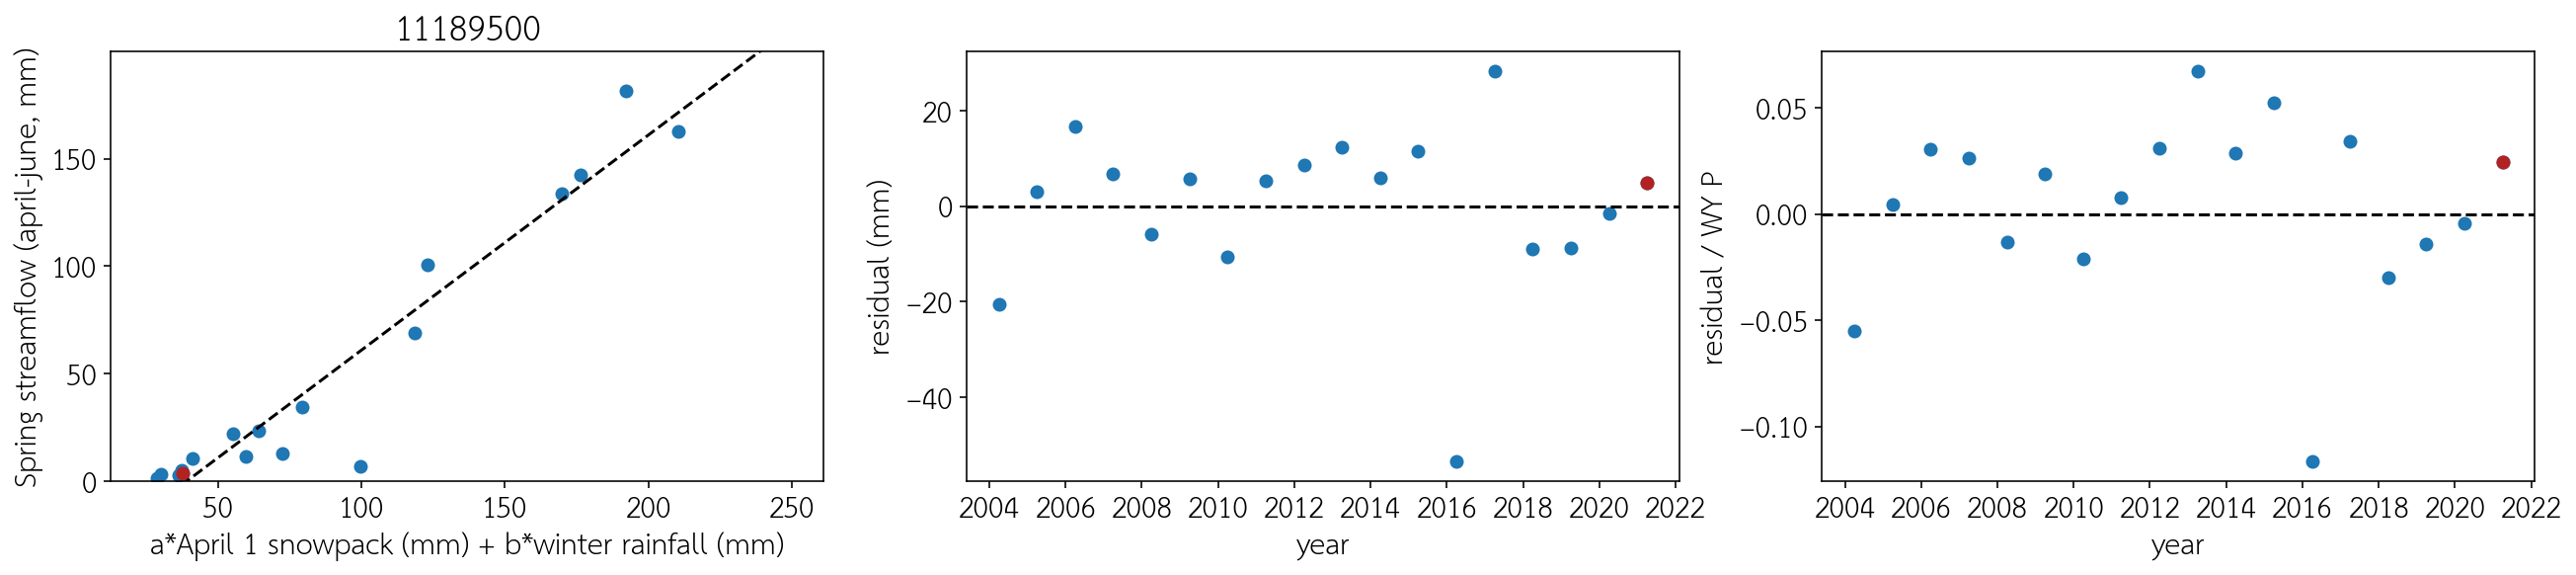

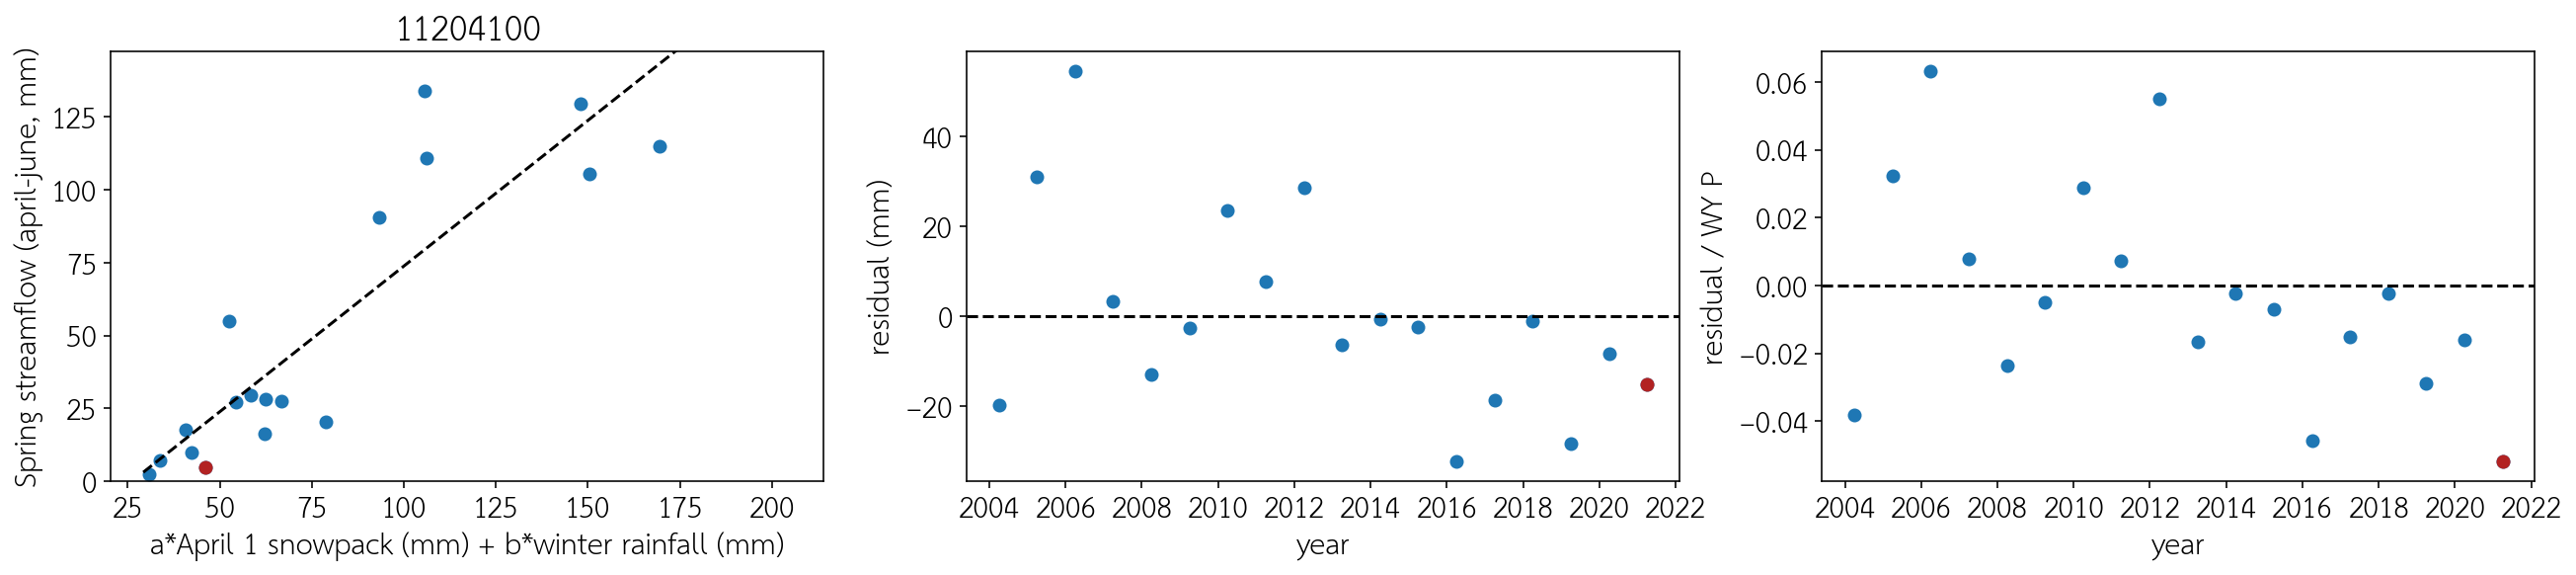

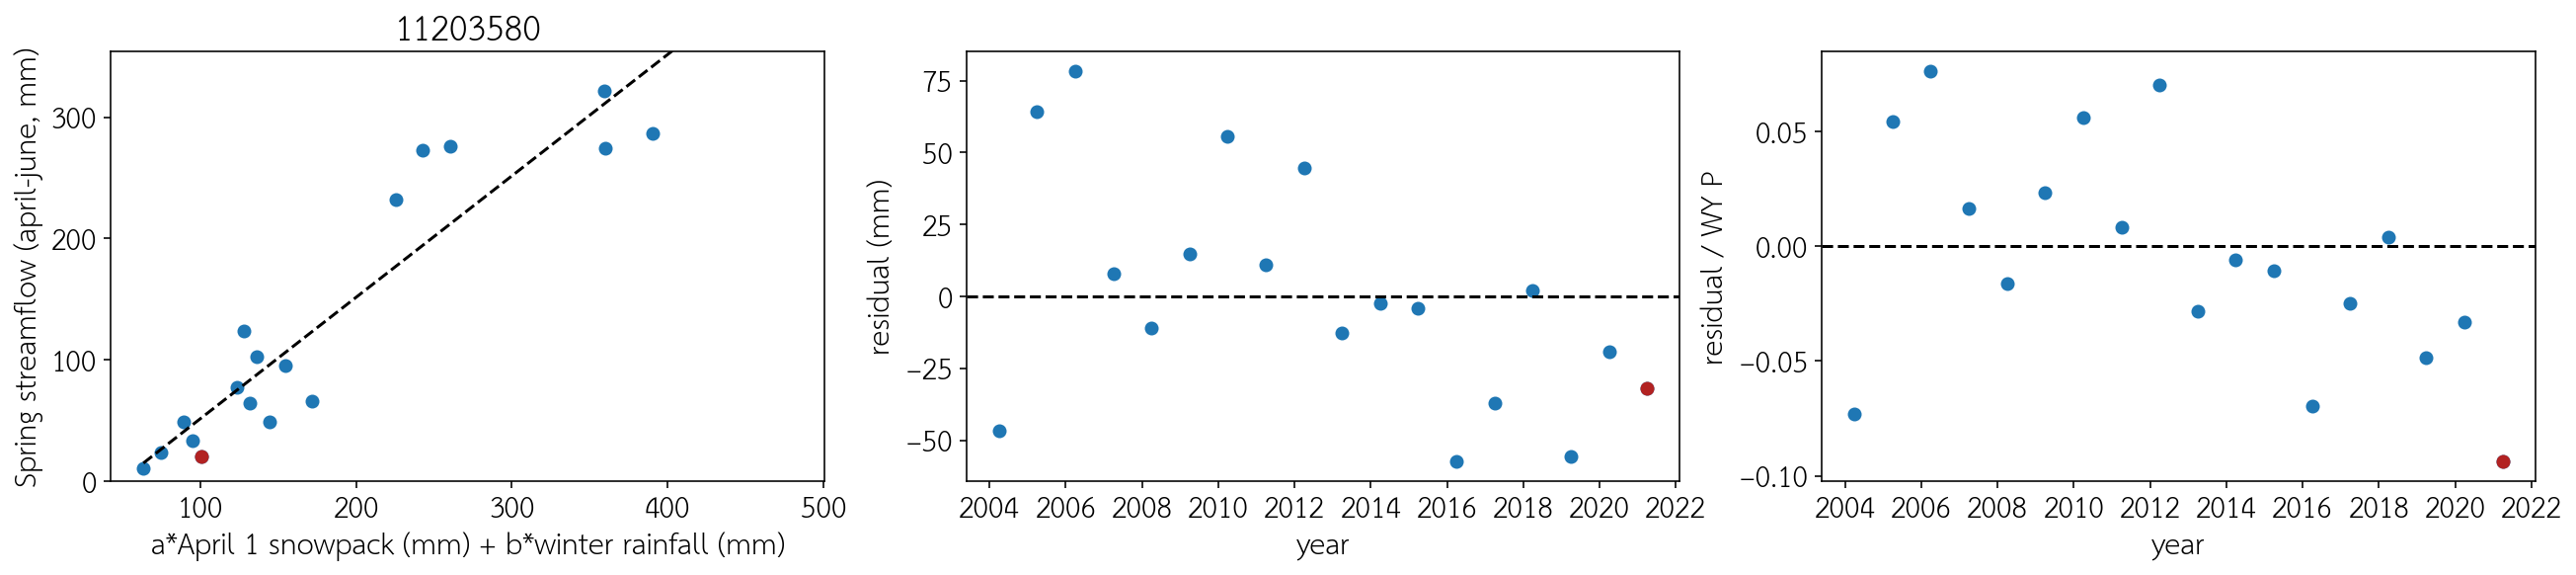

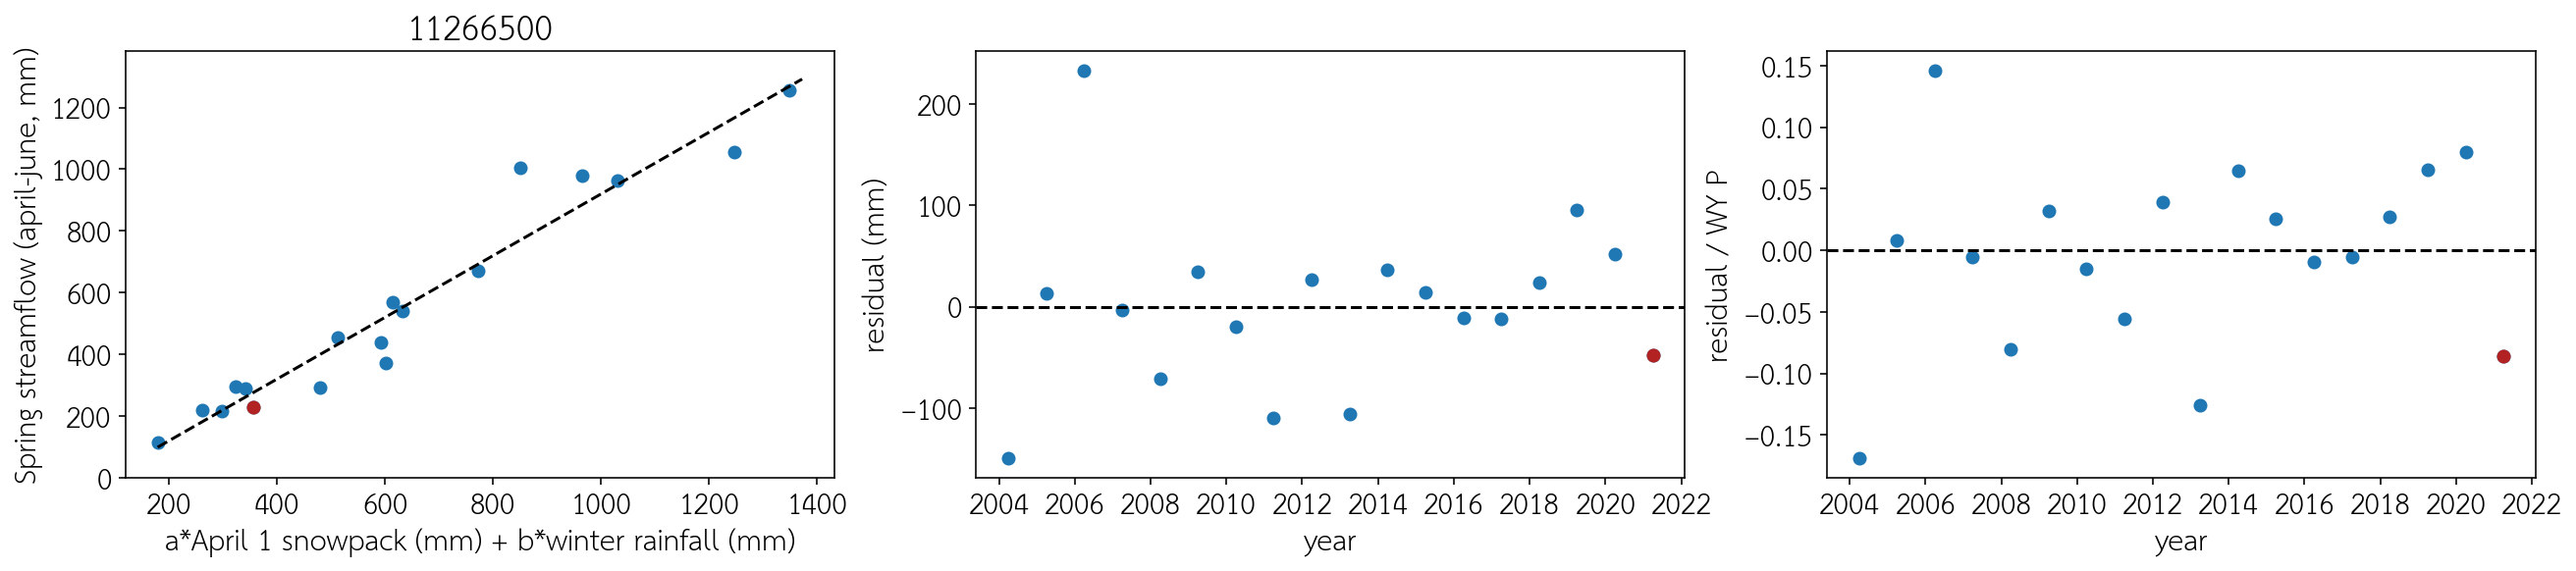

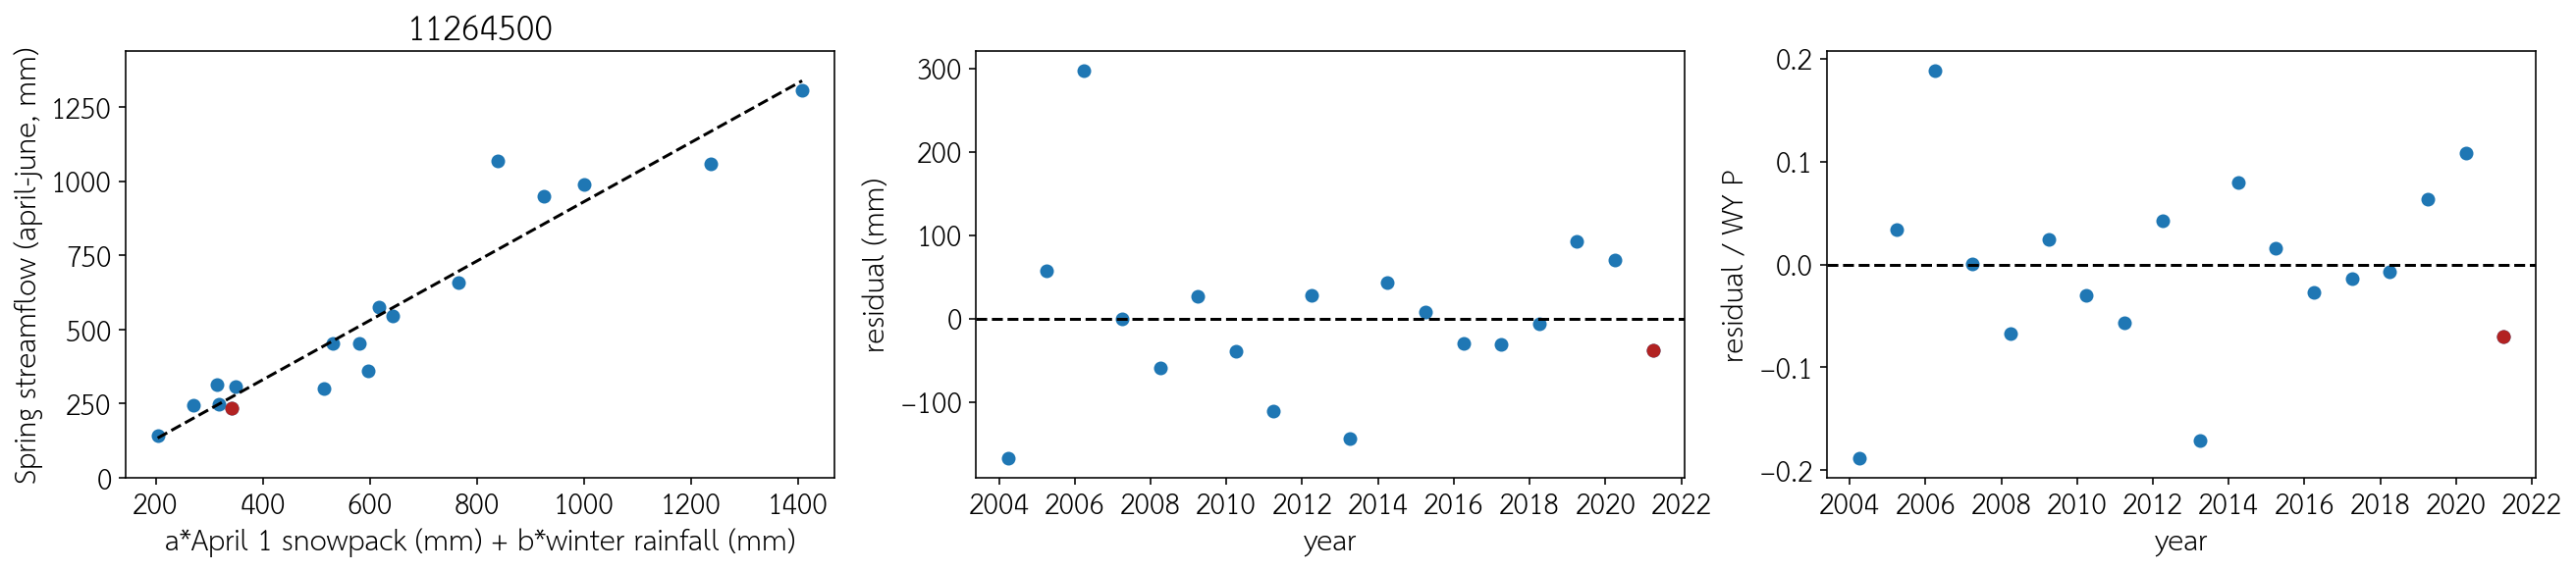

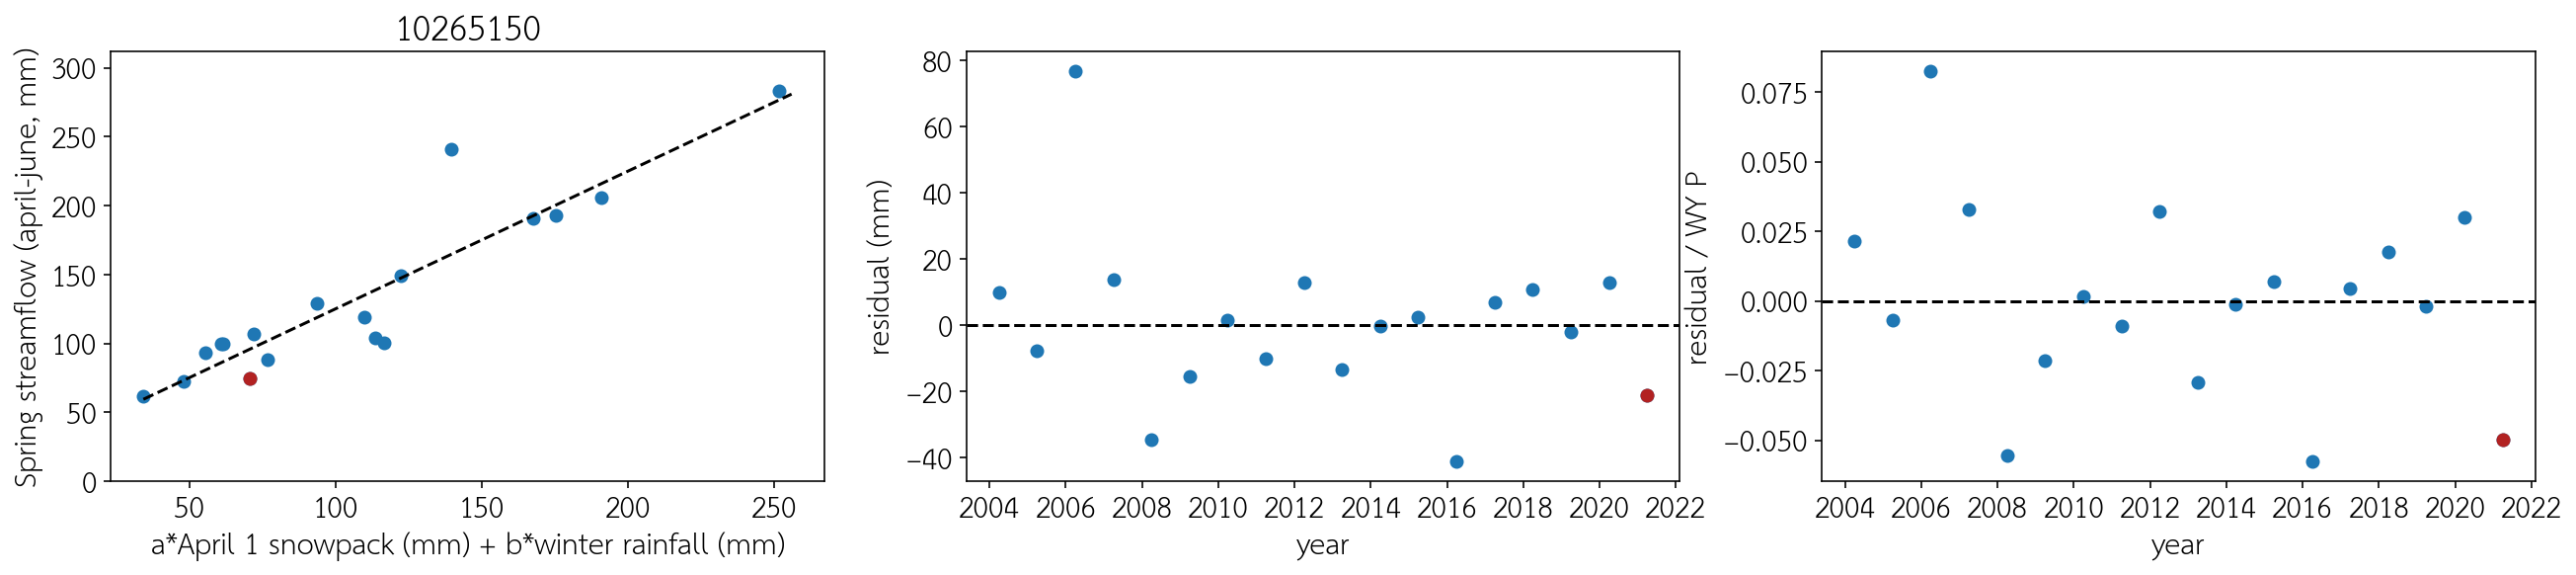

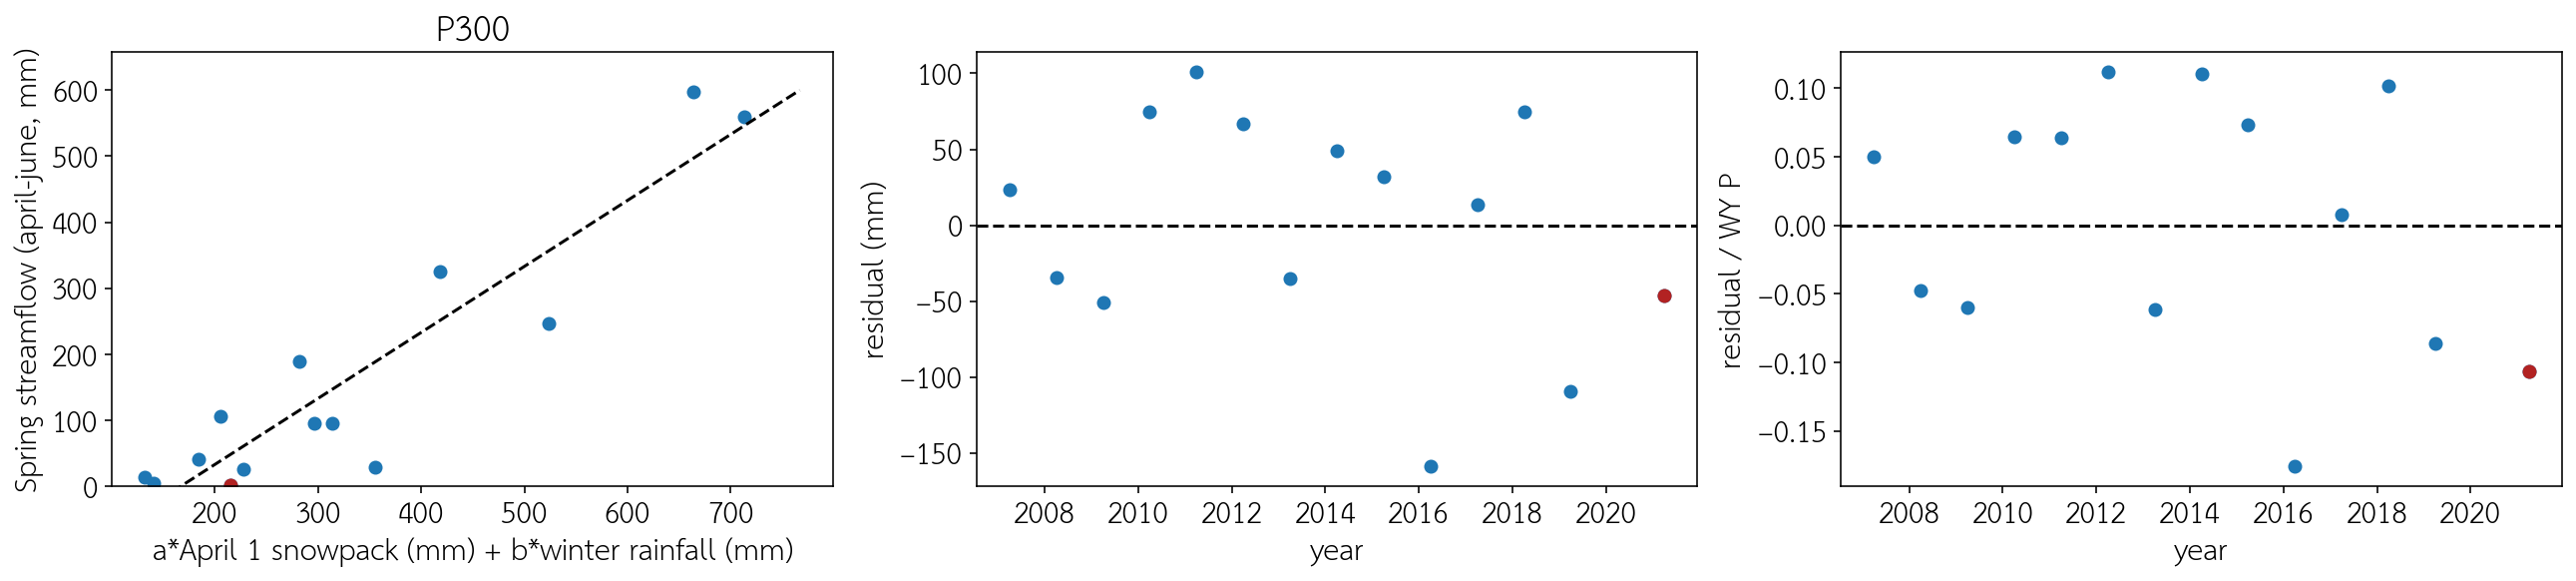

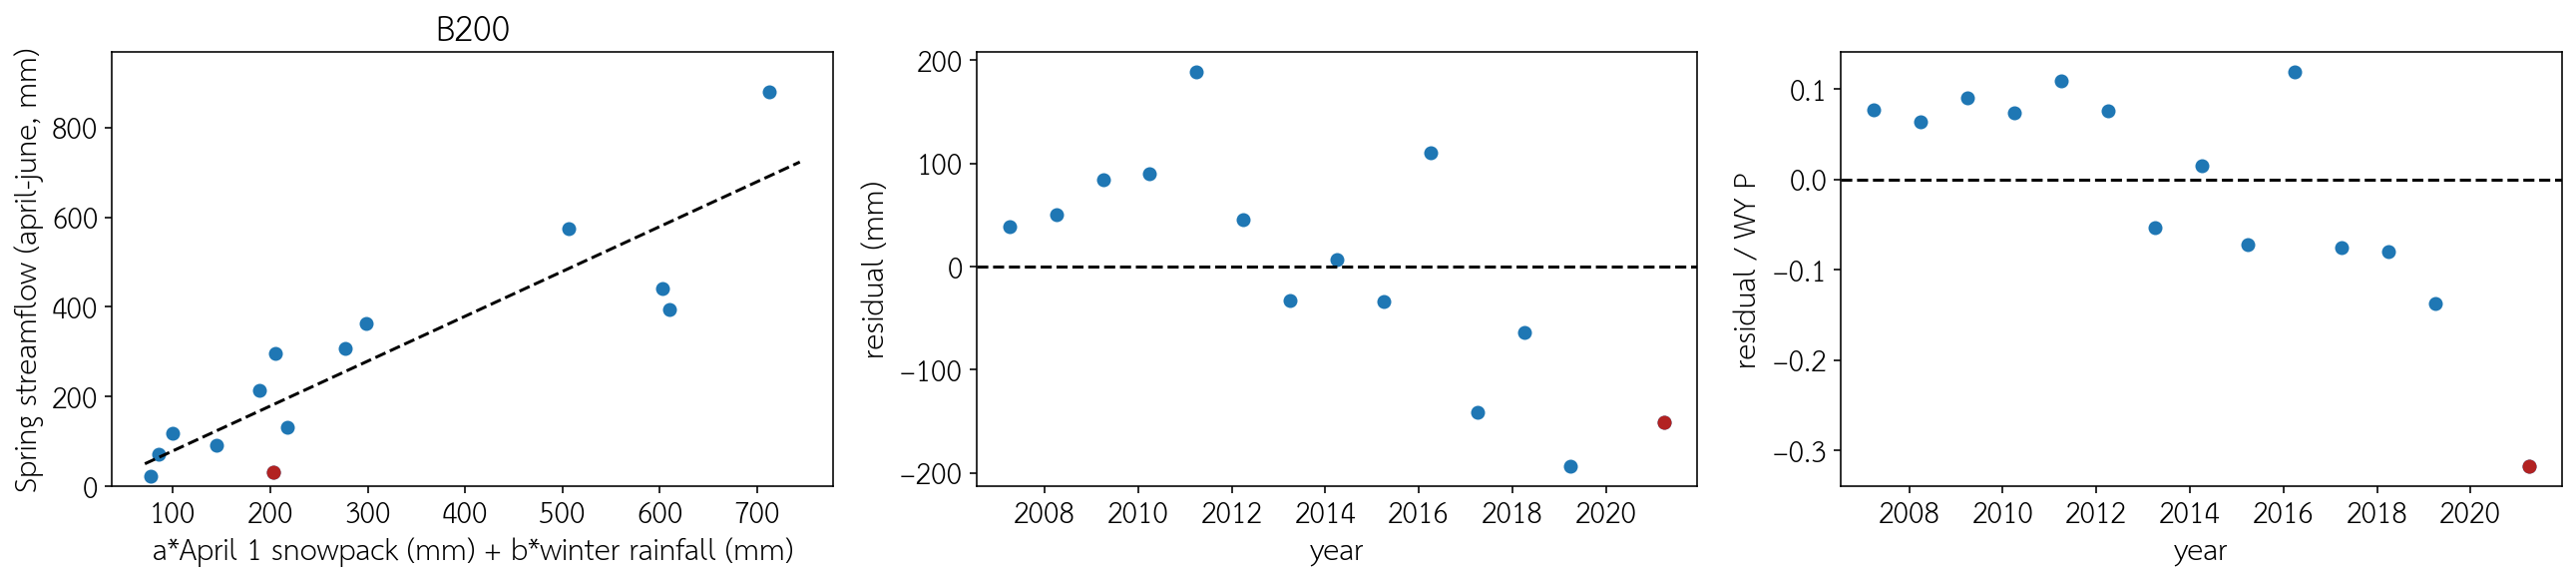

In [89]:
def func(x,a,b,c):
  x1,x2 = x
  return a*x1+b*x2+c
from scipy import stats

# grab April 1 data from each year for each site
snow_data = swe_data[(swe_data.index.month==4) &
                     (swe_data.index.day==1)]


residuals_snodas = {} # residuals in (SWE,P)-Q relationship
snow_data_perc = {} # SWE percentiles
springflow_perc = {} # spring Q percentiles
rain_perc = {}

Pdata=''
for gage in gages.SITE_NO.values:
  
  fig,axs = plt.subplots(1,3,figsize = (22,4))
  yvals =  springflow[gage][-1*len(snow_data):]
  try:
    col = int(gage)
  except:
    col = gage
  snow_mm = snow_data[col]
  mask = (np.isfinite(yvals)) & (np.isfinite(snow_mm.values))

  # get percentiles 
  springflow_perc[gage] = [stats.percentileofscore(yvals, a, 'rank') for a in yvals]
  snow_perc = [stats.percentileofscore(snow_mm, a, 'rank') for a in snow_mm]
  rain_perc[gage] = [stats.percentileofscore(wy_totals[gage].winter_P.values,a,
                                       'rank') for a in wy_totals[gage].winter_P.values]
  snow_data_perc[gage] = snow_perc
  

  # mask by non-inf and non-nan
  snow_mm = snow_mm.values[mask]
  rain = wy_totals[gage].winter_P.values[mask]
  yvals = np.array(yvals)[mask]
  rain_data_all[gage] = wy_totals[gage].winter_P.values

  # fit a relationship between SWE and Q
  popt, pcov = curve_fit(func, (snow_mm,rain), yvals)
  residuals = np.array(yvals) - func((snow_mm,rain), *popt)
  # SS = sum([r**2 for r in residuals])
  # conf = np.sqrt((SS/(len(snow_mm)-3))*np.diagonal(pcov))

  # Leave one out cross-validation
  resids = []
  for i in range(len(snow_mm)):
    snow_mm_test = list(snow_mm.copy())
    rain_test = list(rain.copy())
    snow_mm_test.pop(i)
    rain_test.pop(i)
    yvals_test = list(yvals.copy())
    yvals_test.pop(i)
    popt_test, pcov_test = curve_fit(func, (snow_mm_test, rain_test), yvals_test)
    ypred_test = func((snow_mm[i:i+1],rain[i:i+1]),*popt_test)
    res_test = (yvals[i]-ypred_test[0])
    resids.append(abs(res_test))
  res_test = np.nanmean(resids)
  print('LOO',res_test)

  # add back in spaces where inf and nan vals were to retain correct years
  residuals1 = []
  j=0
  for i in range(len(mask)):
    if mask.iloc[i]==True:
      residuals1.append(residuals[j])
      j+=1
    else:
      residuals1.append(np.nan)
  residuals = residuals1
  
  # plot the results
  ax = axs[0]
  ax.scatter(snow_mm*popt[0]+rain*popt[1],yvals)
  ax.set_xlabel('a*April 1 snowpack (mm) + b*winter rainfall (mm)')
  ax.set_ylabel('Spring streamflow (april-june, mm)')
  # ax.scatter(snow_mm[-1:],springflow[gage][-1:],
  #             c='firebrick')
  ax.scatter(snow_mm[-1:]*popt[0]+rain[-1:]*popt[1],yvals[-1:],
             c='firebrick')
  xvals = (np.linspace(np.nanmin(snow_mm),np.nanmax(snow_mm)),
           np.linspace(np.nanmin(rain),np.nanmax(rain)))
  ax.plot(func(xvals,*popt)-popt[2],func(xvals,*popt),c='k',ls='--')
 
  from scipy.stats.distributions import  t

  alpha = 0.25 # 95% confidence interval = 100*(1-alpha)

  n = len(xvals[0])    # number of data points
  p = len(popt) # number of parameters

  dof = max(0, n - p) # number of degrees of freedom

  # # student-t value for the dof and confidence level
  # tval = t.ppf(1.0-alpha/2., dof) 
  # pmins = []
  # pmaxs = []
  # for i, p, var in zip(range(n), popt, np.diag(pcov)):
  #     sigma = var**0.5
  #     # print ('p{0}: {1} [{2}  {3}]'.format(i, p,
  #     #                               p - sigma*tval,
  #     #                               p + sigma*tval))
  #     pmins.append(p - sigma*tval)
  #     pmaxs.append(p + sigma*tval)
  # print(snow_mm[-1]*pmins[0]+rain[-1]*pmins[1]+pmins[2],
  #       snow_mm[-1]*pmaxs[0]+rain[-1]*pmaxs[1]+pmaxs[2],
  #       yvals[-1])


  ax.set_title(gage)
  ax.set_ylim(0,np.nanmax(springflow[gage])*1.1)

  ax = axs[1]
  ax.scatter(snow_data.index.values[-len(residuals):],residuals)#/snow_mm)
  ax.set_xlabel('year')
  ax.set_ylabel('residual (mm)')
  # ax.set_ylim(-1,1)
  ax.axhline(0,ls='--',c='k')
  ax.scatter(snow_data.index.values[-1:],residuals[-1:]#/snow_mm[-1:]
             ,c='firebrick')
  residuals_snodas[gage] = np.where(np.isfinite(residuals),#/snow_mm),
                                    residuals,#/snow_mm,
                                    np.nan)
  
  ax = axs[2]
  loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/MODIS_and_PRISM_data/modis_data_'
  pdata = pd.read_csv(loc+str(gage)+'.csv')
  pdata = pdata.groupby('wy').sum().P.to_frame().rename(columns={'P':gage})
  if len(Pdata)==0:
    Pdata = pdata
  else:
    Pdata = Pdata.merge(pdata,left_index=True,right_index=True)
  ax.scatter(snow_data.index[-len(residuals):],residuals/Pdata[gage].values[-len(residuals):])
  ax.set_xlabel('year')
  ax.set_ylabel('residual / WY P')
  # ax.set_ylim(-1,1)
  ax.axhline(0,ls='--',c='k')
  ax.scatter(snow_data.index.values[-1:],residuals[-1:]/Pdata[gage].values[-1:]
             ,c='firebrick')

In [18]:
# save residuals so they're all the same length and can be put into a dataframe

maxlen = 0
for key in residuals_snodas.keys():
  if len(residuals_snodas[key])>maxlen:
    maxlen = len(residuals_snodas[key])

for key in residuals_snodas.keys():
  if len(residuals_snodas[key])<maxlen:
    residuals_snodas[key] = list(residuals_snodas[key]) + [np.nan]*(maxlen-len(residuals_snodas[key]))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'winter_P_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


LOO 18.05883206151972


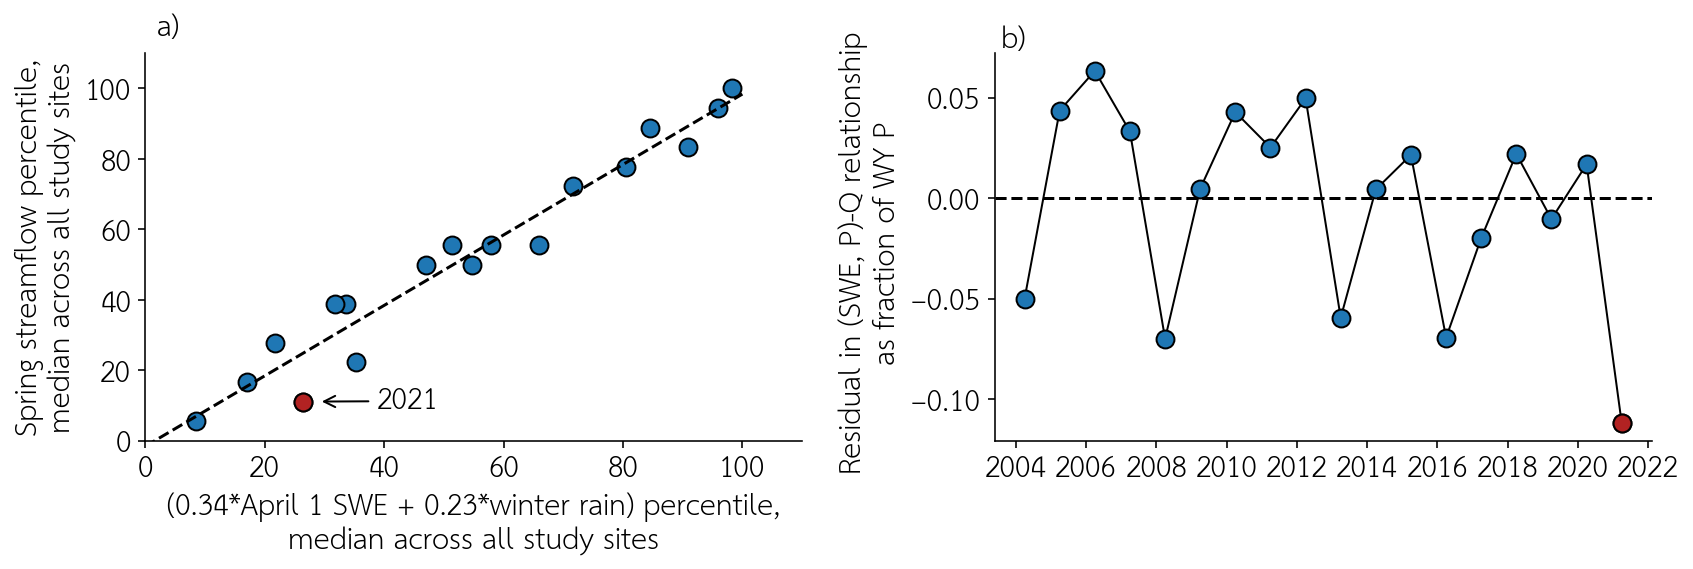

In [90]:
# make publication figure with aggregated data across all study sites

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update({'font.size': 14})
def func(x,a,b,c):
  x,y = x
  return a*x+b*y+c
newlist = []#['B200']#'P300']#,'B200']
snow_data_perc1 = pd.DataFrame.from_dict(snow_data_perc)[[c for c in snow_data_perc.keys() if c not in newlist]].median(axis=1)
springflow_perc_all1 = pd.DataFrame.from_dict(springflow_perc)[[c for c in springflow_perc.keys() if c not in newlist]].median(axis=1)
snow_data_all1 = snow_data[[c for c in snow_data.columns if c not in newlist]].mean(axis=1)
springflow_all1 = pd.DataFrame.from_dict(springflow)[[c for c in springflow.keys() if c not in newlist]].mean(axis=1)
rain_data_all = ''
snow_data_all = ''
for g in wy_totals.keys():
  if len(rain_data_all)==0:
    rain_data_all = wy_totals[g][['winter_P']]
    snow_data_all = wy_totals[g]
  else:
    rain_data_all = rain_data_all.merge(wy_totals[g]['winter_P'],
                                        left_index=True,right_index=True)
rain_data_all = rain_data_all.mean(axis=1)
rain_percentiles = pd.DataFrame.from_dict(rain_perc).mean(axis=1)
residuals_all1 = pd.DataFrame.from_dict(residuals_snodas)[[c for c in residuals_snodas.keys() if c not in newlist]].mean(axis=1)
residuals_all1 = residuals_all1.values/Pdata[[c for c in Pdata.columns if c not in newlist]].mean(axis=1).iloc[-len(residuals_all1):].values
  
fig,axs = plt.subplots(1,2,figsize = (12,4),
                       )
snow_mm = snow_data_perc1#snow_data_all
yvals =  springflow_perc_all1#springflow_all[-1*len(snow_mm):]

# popt, pcov = curve_fit(func, snow_mm, yvals)
# residuals = np.array(yvals) - func(np.array(snow_mm), *popt)

popt1, pcov1 = curve_fit(func, (snow_data_perc1, rain_percentiles), 
                         springflow_perc_all1[-1*len(snow_mm):])
residuals1 = np.array(springflow_perc_all1[-1*len(snow_data_perc1):]) - func((snow_data_perc1, rain_percentiles), *popt1)

# Leave one out cross-validation
preds = []
for i in range(len(snow_data_perc1)):
  snow_mm_test = list(snow_data_perc1.copy())
  rain_test = list(rain_percentiles.copy())
  snow_mm_test.pop(i)
  rain_test.pop(i)
  yvals_test = list(springflow_perc_all1.copy())
  yvals_test.pop(i)
  popt_test, pcov_test = curve_fit(func, (snow_mm_test, rain_test), yvals_test)
  ypred_test = func((snow_mm[i:i+1].values,np.array(rain_test[i:i+1])),*popt_test)
  residual_test = (yvals[i]-ypred_test)
  try:
    preds.append(abs(residual_test[0]))
  except:
    preds.append(np.nan)
mean_residual = np.nanmean(preds)
print('LOO',mean_residual)

size=80
ax = axs[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter(func((snow_data_perc1, rain_percentiles),*popt1)-popt1[2],yvals,s=size,edgecolor = 'k')
ax.set_xlabel('(%1.2f*April 1 SWE + %1.2f*winter rain) percentile,\nmedian across all study sites' %(popt[0],popt[1]))
ax.set_ylabel('Spring streamflow percentile,\nmedian across all study sites')

colors = ['firebrick','goldenrod']
j=0
for i in ([2021]):#,2008]):
  # ax.annotate(str(i), xy=(snow_mm[17-2021+i:17-2021+i+1],yvals[17-2021+i:17-2021+i+1]),
  #             xytext=(snow_mm[17-2021+i:17-2021+i+1], yvals[17-2021+i:17-2021+i+1]/4) , 
  #           horizontalalignment="center",arrowprops=dict(arrowstyle='->',lw=1)
  #           )
  ax.annotate(str(i), xy=(snow_mm[17-2021+i:17-2021+i+1]-10,yvals[17-2021+i:17-2021+i+1]),
              xytext=(snow_mm[17-2021+i:17-2021+i+1]+15-10, yvals[17-2021+i:17-2021+i+1]-2) , 
            horizontalalignment="center",arrowprops=dict(arrowstyle='->',lw=1)
            )
  ax.scatter(func((snow_data_perc1[-1:], rain_percentiles[-1:]),*popt1).values-popt1[2],
             yvals[-1:],
            c=colors[j],label='2021',s=size,edgecolor = 'k')
  j+=1
# ax.legend(loc='upper left',frameon=False)
xvals = np.linspace(0,100)
ax.plot(xvals,xvals+popt1[2],c='k',ls='--')
ax.set_xlim(0,110)
ax.set_ylim(0,110)#np.nanmax(springflow_all)*1.1)


# ax = inset_axes(ax, width="40%", height="40%", loc=4,
#                   bbox_to_anchor=(-.3,0.57,0.8,0.9),
#                   bbox_transform=ax.transAxes)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_ylabel('Mean Q (mm)',fontsize = 12)
# ax.set_xlabel('Mean SWE (mm)', fontsize = 12)
# ax.scatter(snow_data_all1,springflow_all1[-1*len(snow_mm):]
#            ,edgecolor = 'k')
# ax.scatter(snow_data_all1[-1:],springflow_all1[-1:]
#            ,edgecolor = 'k',c='firebrick')
# # ax.scatter(snow_data_all1[4:5],(springflow_all1[-1*len(snow_mm):])[4:5]
# #            ,edgecolor = 'k',c='goldenrod')
# xvals = np.linspace(np.nanmin(snow_data_all1),np.nanmax(snow_data_all1))
# ax.plot(xvals,func(xvals,*popt1),c='k',ls='--')
# ax.set_xticklabels([0,500,1000],fontsize = 12)
# ax.set_yticklabels([0,500,1000],fontsize = 12)


ax = axs[1]
ax.plot(snow_data.index,residuals_all1,c='k',lw=1,zorder = -1)
ax.scatter(snow_data.index,residuals_all1,s=size,edgecolor = 'k')
# ax.set_ylim(-.5,.5)
ax.set_ylabel('Residual in (SWE, P)-Q relationship \n as fraction of WY P')
ax.axhline(0,ls='--',c='k')
j=0
for i in [2021]:#,2008]:
  if i==2021:
    x = snow_data.index.values[-1:]
    y=residuals_all1[-1:]
  else:
    x = snow_data.index.values[4:5]
    y=residuals_all1[4:5]
  ax.scatter(x,y,c=colors[j],s=size,edgecolor = 'k')
  j+=1
residuals_snodas['all_sites'] = residuals_all1
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

axs[1].set_xlabel('')

fig.tight_layout()
axs[0].text(2,115,'a)')
axs[1].text(pd.to_datetime('8-1-2003'),.075,'b)')

plt.savefig('SWE_Q_relationship.pdf',format='pdf',bbox_inches = 'tight')

## Save data for access in other notebooks

In [ ]:
snow_data_save = snow_data
snow_data_save['wy'] = snow_data_save.index.year
snow_data_save = snow_data_save.reset_index().drop(columns='date').set_index('wy')

springflow_df = pd.DataFrame.from_dict(springflow)
springflow_df['wy'] = list(range(2022-len(springflow_df),2022))
springflow_df = springflow_df.set_index('wy')

residuals_df = pd.DataFrame.from_dict(residuals_snodas)
residuals_df['wy'] = list(range(2022-len(residuals_df),2022))
residuals_df = residuals_df.set_index('wy')

snow_data_save.to_csv('april_swe_study_sites_mm.csv')
springflow_df.to_csv('spring_streamflow_mm.csv')
residuals_df.to_csv('swe_q_residuals_mm.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
func((snow_data_perc1[-1:], rain_percentiles[-1:]),*popt1).values[0]#,yvals[-1]

24.890916518652805